In [7]:
!pip install -q efficientnet
import pandas as pd
import numpy as np
from scipy import stats
import random
import os
import tensorflow as tf
import math
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import re
import tensorflow.keras.applications.efficientnet as eff
import tensorflow.keras.applications as tfka
import efficientnet.tfkeras as efn
from sklearn import metrics
import gc
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-11-26 20:06:28.928725: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-26 20:06:28.928800: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30043}
2021-11-26 20:06:28.933840: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-26 20:06:28.934143: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30043}


REPLICAS:  8


In [9]:
# Configuration
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = [256, 256]
# Seed
SEED = 9527
seed = 9527
# Learning rate
LR = 0.0005
# Verbosity
VERBOSE = 2
# Label_dim
label_dim = 35

# dataset path

img_path = '../input/deepfoodie/dataset_1_images/dataset_1_images/Food Images/'
GCS_PATH = KaggleDatasets().get_gcs_path('deepfoodiedataloaders')

train_set = tf.io.gfile.glob(GCS_PATH + '/train' + '*.tfrec')
val_set = tf.io.gfile.glob(GCS_PATH + '/val' + '*.tfrec')

TARGET = "cleaned_ingredients"
VOCAB_SIZE = 13528

In [10]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Data augmentation function
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image


# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "cleaned_ingredients": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "orig_ingredients": tf.io.FixedLenFeature([], tf.string),
        "title": tf.io.FixedLenFeature([], tf.string),
        "instructions": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    title = example['title']
    label = example['cleaned_ingredients']
    return  image, label

def load_dataset(filenames, target, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, target, ordered = False):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our validation tensors
def get_validation_dataset(filenames, target, ordered = True):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Function to count how many photos we have in
def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_set)
print(f'Dataset: {NUM_TRAINING_IMAGES} training images')

Dataset: 10092 training images


In [11]:
train_dataset = get_training_dataset(train_set, TARGET, ordered = False)

In [12]:
for fo in train_dataset.take(1):
    print(fo[1], fo[0][1])
    print(fo[0][0].shape)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(32, 13528), dtype=int64) tf.Tensor(
[[[0.83930725 0.841004   0.8449279 ]
  [0.83930725 0.841004   0.8449279 ]
  [0.8355512  0.83724797 0.84117186]
  ...
  [0.80174667 0.7859313  0.76984614]
  [0.80174667 0.7859313  0.76984614]
  [0.7979906  0.7821752  0.7660901 ]]

 [[0.8430633  0.84476006 0.84868395]
  [0.83930725 0.841004   0.8449279 ]
  [0.8355512  0.83724797 0.84117186]
  ...
  [0.80174667 0.7859313  0.76984614]
  [0.80174667 0.7859313  0.76984614]
  [0.7979906  0.7821752  0.7660901 ]]

 [[0.8430633  0.84476006 0.84868395]
  [0.8430633  0.84476006 0.84868395]
  [0.83930725 0.841004   0.8449279 ]
  ...
  [0.7979906  0.7890388  0.7695011 ]
  [0.7979906  0.7890388  0.7695011 ]
  [0.7979906  0.7890388  0.7695011 ]]

 ...

 [[0.16237901 0.2481011  0.34537262]
  [0.16237901 0.2481011  0.34537262]
  [0.16341414 0.25267184 0.35664076]
  ...
  [0.0649826

In [13]:
val_dataset = get_validation_dataset(val_set, TARGET, ordered = True)

2021-11-26 20:06:41.754539: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 74, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637957201.751241246","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 74, Output num: 1","grpc_status":3}


In [14]:
STEPS_PER_EPOCH = count_data_items(train_set) // BATCH_SIZE
K.clear_session()


In [15]:
def get_lr_callback():
    # lr_start   = 0.0000001
    # lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.0000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < EPOCHS/2:
            lr = 0.000001 * (BATCH_SIZE - epoch)
        else:
            lr = lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [16]:
def get_model(mode):

    with strategy.scope():

        inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
    #     inp2 = tf.keras.layers.Input(shape = (MAX_LEN,))
    #     print(f'load Model_{mode}')
    #     y = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inp2)
    #     y = tf.keras.layers.Dropout(.5)(y)
    #     y = tf.keras.layers.LSTM(128)(y)
        if mode == 'eff0':
            x = efn.EfficientNetB0(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff1':
            x = efn.EfficientNetB1(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff2':
            x = efn.EfficientNetB2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff3':
            x = efn.EfficientNetB3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff4':
            x = efn.EfficientNetB4(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff5':
            x = efn.EfficientNetB5(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff6':
            x = efn.EfficientNetB6(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff7':
            x = efn.EfficientNetB7(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV2':
            x = tfka.InceptionResNetV2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV3':
            x = tfka.InceptionV3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'XCP':
            x = tfka.Xception(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG16':
            x = tfka.VGG16(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG19':
            x = tfka.VGG19(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'RN50':
            x = tfka.ResNet50(weights = 'imagenet', include_top = False)(inp)
        else:
            # 'RN101'
            x = tfka.ResNet101(weights = 'imagenet', include_top = False)(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        x = tf.keras.layers.Dense(256)(x)

        output = tf.keras.layers.Dense(VOCAB_SIZE, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs = [inp], outputs = [output])
        opt = tf.keras.optimizers.Adam(learning_rate = LR)

        model.compile(
            optimizer = opt,
            loss="binary_crossentropy"

            ) 

        return model

In [17]:
def plot_model(mode):
    model = get_model(mode=mode)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Model_{mode}_{505}.h5', 
                                                        monitor = 'val_loss', 
                                                        verbose = 2, 
                                                        save_best_only = True,
                                                        save_weights_only = True, 
                                                        mode = 'min')
    history = model.fit(train_dataset,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            callbacks = [checkpoint, get_lr_callback()], 
                            validation_data = val_dataset,
                            verbose = VERBOSE)
    
    gc.collect()
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

27164672/27164032 [==============================] - 0s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 91s - loss: 0.1983 - val_loss: 0.0507


2021-11-26 20:08:31.630075: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 38774, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637957311.629654487","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 38774, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05069, saving model to Model_eff1_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 18s - loss: 0.0067 - val_loss: 0.0309

Epoch 00002: val_loss improved from 0.05069 to 0.03089, saving model to Model_eff1_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 18s - loss: 0.0045 - val_loss: 0.0233

Epoch 00003: val_loss improved from 0.03089 to 0.02329, saving model to Model_eff1_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 18s - loss: 0.0041 - val_loss: 0.0199

Epoch 00004: val_loss improved from 0.02329 to 0.01988, saving model to Model_eff1_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 19s - loss: 0.0040 - val_loss: 0.0159

Epoch 00005: val_loss improved from 0.01988 to 0.01586, saving model to Model_eff1_505.h5
Epoch 6/10

Ep

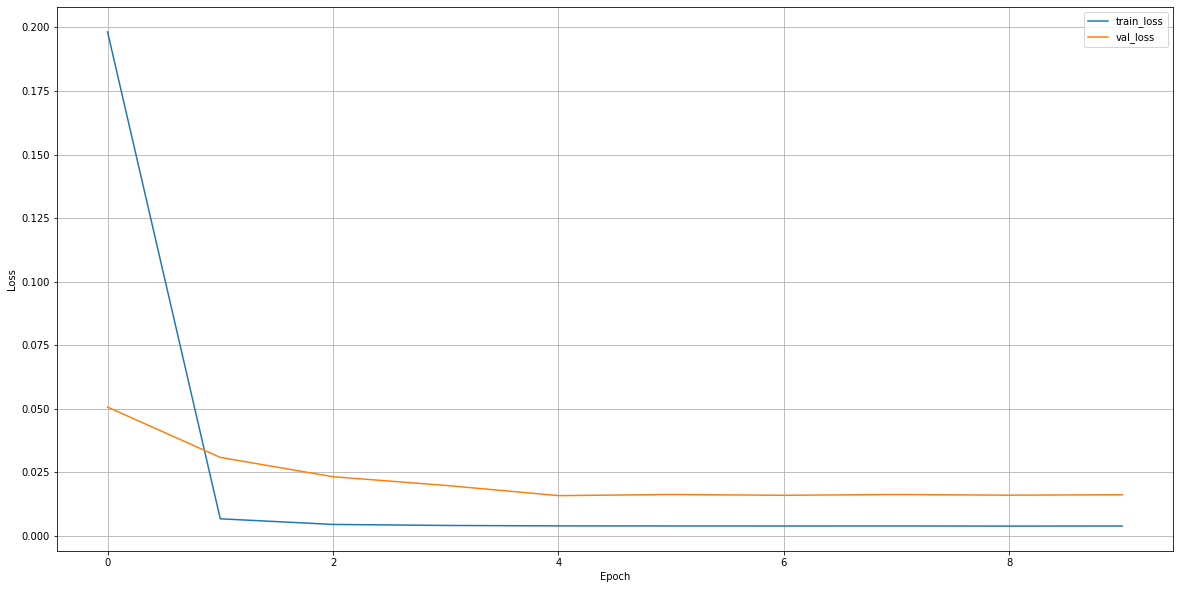

In [18]:
models = ['eff1','eff2','eff3','eff4','eff5','eff6','eff7','XCP', 'RN50']
plot_model(models[0])

31940608/31936256 [==============================] - 0s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 95s - loss: 0.2047 - val_loss: 0.0560


2021-11-26 20:13:21.071771: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 108000, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637957601.071190704","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 108000, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05598, saving model to Model_eff2_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 19s - loss: 0.0069 - val_loss: 0.0337

Epoch 00002: val_loss improved from 0.05598 to 0.03375, saving model to Model_eff2_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 19s - loss: 0.0048 - val_loss: 0.0244

Epoch 00003: val_loss improved from 0.03375 to 0.02439, saving model to Model_eff2_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 20s - loss: 0.0042 - val_loss: 0.0232

Epoch 00004: val_loss improved from 0.02439 to 0.02319, saving model to Model_eff2_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 19s - loss: 0.0040 - val_loss: 0.0164

Epoch 00005: val_loss improved from 0.02319 to 0.01635, saving model to Model_eff2_505.h5
Epoch 6/10

Ep

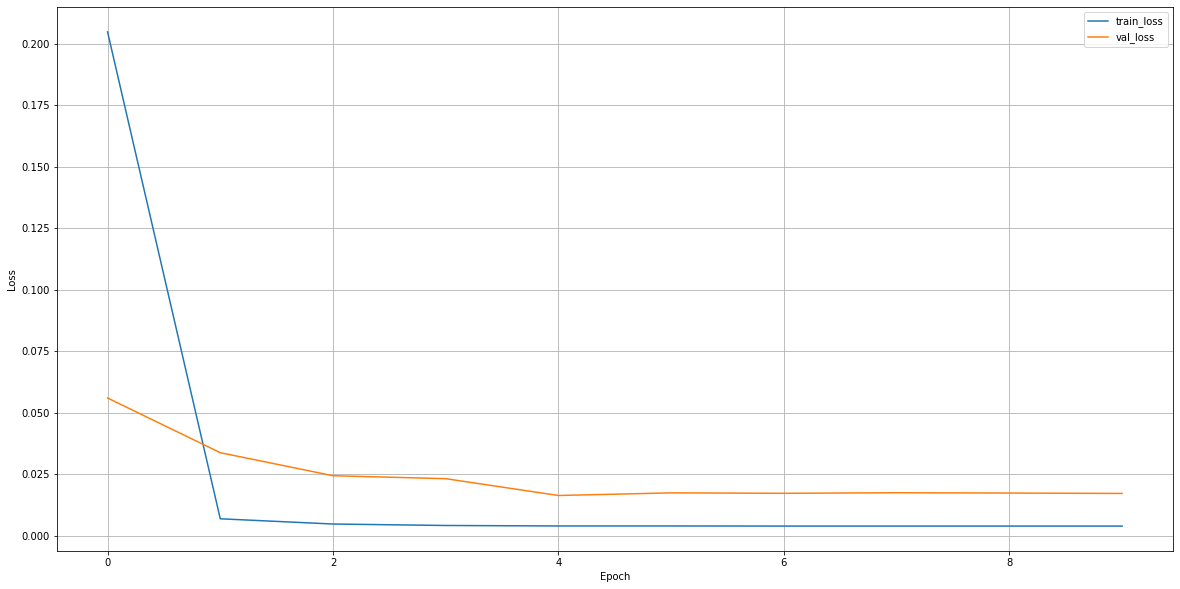

In [19]:
plot_model(models[1])

44113920/44107200 [==============================] - 0s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 105s - loss: 0.1930 - val_loss: 0.0568


2021-11-26 20:18:29.592012: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 182069, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637957909.591764606","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 182069, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05682, saving model to Model_eff3_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 21s - loss: 0.0063 - val_loss: 0.0375

Epoch 00002: val_loss improved from 0.05682 to 0.03748, saving model to Model_eff3_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 21s - loss: 0.0045 - val_loss: 0.0284

Epoch 00003: val_loss improved from 0.03748 to 0.02843, saving model to Model_eff3_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 21s - loss: 0.0041 - val_loss: 0.0219

Epoch 00004: val_loss improved from 0.02843 to 0.02185, saving model to Model_eff3_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 21s - loss: 0.0040 - val_loss: 0.0170

Epoch 00005: val_loss improved from 0.02185 to 0.01696, saving model to Model_eff3_505.h5
Epoch 6/10

Ep

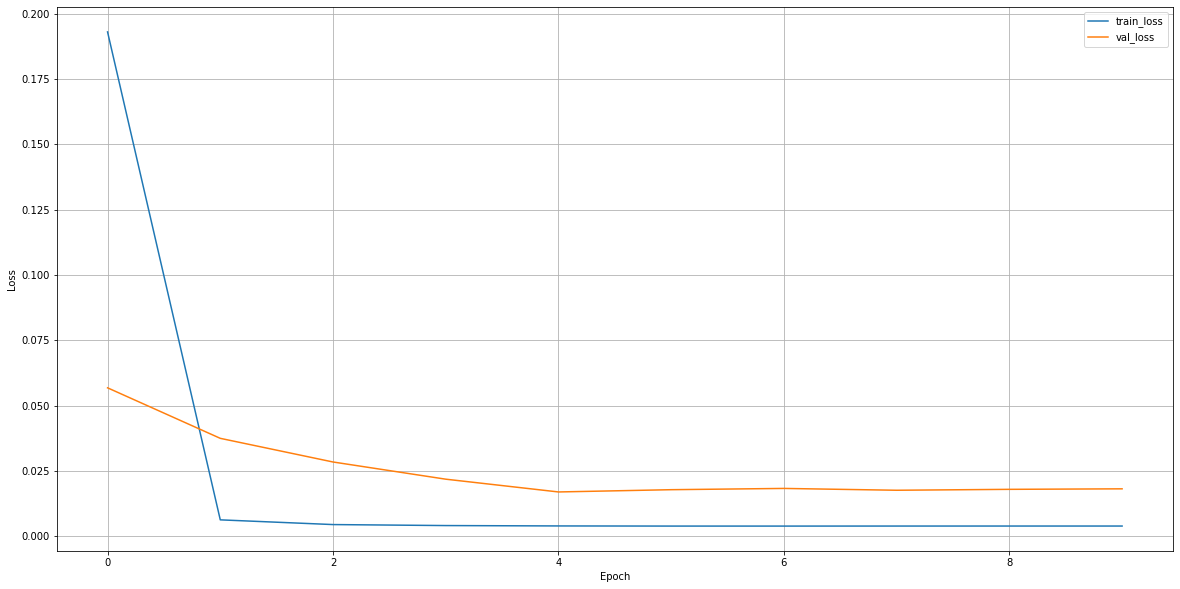

In [20]:
plot_model(models[2])

71892992/71892840 [==============================] - 1s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 132s - loss: 0.2239 - val_loss: 0.1217


2021-11-26 20:24:28.454304: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 268769, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637958268.454209888","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 268769, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.12168, saving model to Model_eff4_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 26s - loss: 0.0072 - val_loss: 0.0885

Epoch 00002: val_loss improved from 0.12168 to 0.08848, saving model to Model_eff4_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 26s - loss: 0.0047 - val_loss: 0.0598

Epoch 00003: val_loss improved from 0.08848 to 0.05982, saving model to Model_eff4_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 26s - loss: 0.0043 - val_loss: 0.0408

Epoch 00004: val_loss improved from 0.05982 to 0.04085, saving model to Model_eff4_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 26s - loss: 0.0040 - val_loss: 0.0329

Epoch 00005: val_loss improved from 0.04085 to 0.03292, saving model to Model_eff4_505.h5
Epoch 6/10

Ep

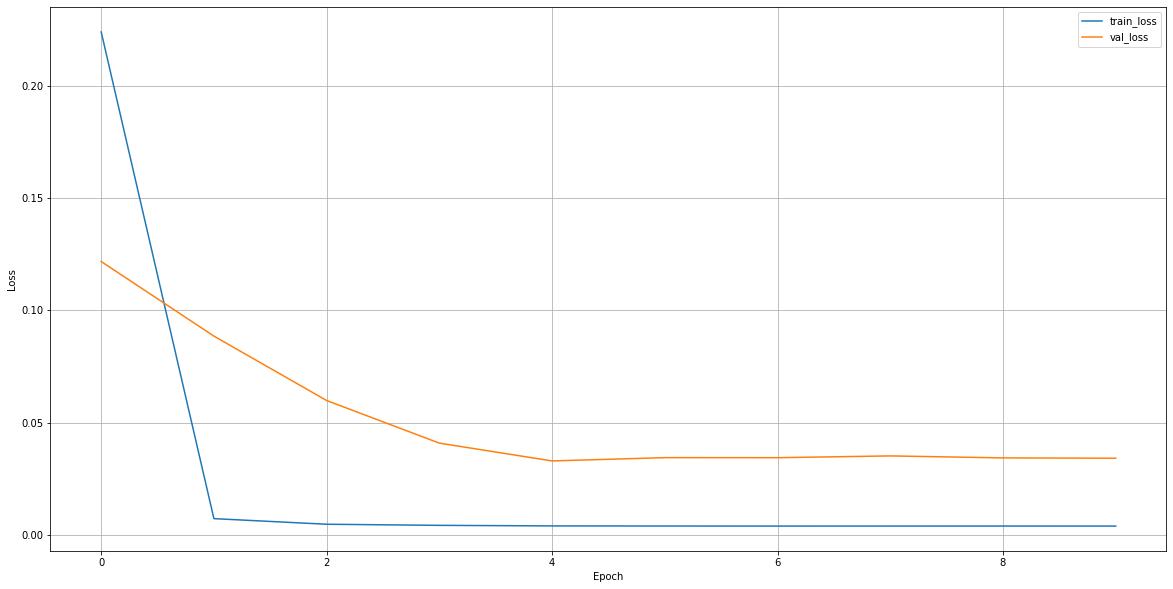

In [21]:
plot_model(models[3])

115515392/115515256 [==============================] - 1s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 167s - loss: 0.2193 - val_loss: 0.0466


2021-11-26 20:31:50.958211: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 372241, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637958710.957907618","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 372241, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.04659, saving model to Model_eff5_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 31s - loss: 0.0063 - val_loss: 0.0139

Epoch 00002: val_loss improved from 0.04659 to 0.01390, saving model to Model_eff5_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 31s - loss: 0.0045 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.01390 to 0.00809, saving model to Model_eff5_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 31s - loss: 0.0043 - val_loss: 0.0059

Epoch 00004: val_loss improved from 0.00809 to 0.00591, saving model to Model_eff5_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 31s - loss: 0.0039 - val_loss: 0.0055

Epoch 00005: val_loss improved from 0.00591 to 0.00547, saving model to Model_eff5_505.h5
Epoch 6/10

Ep

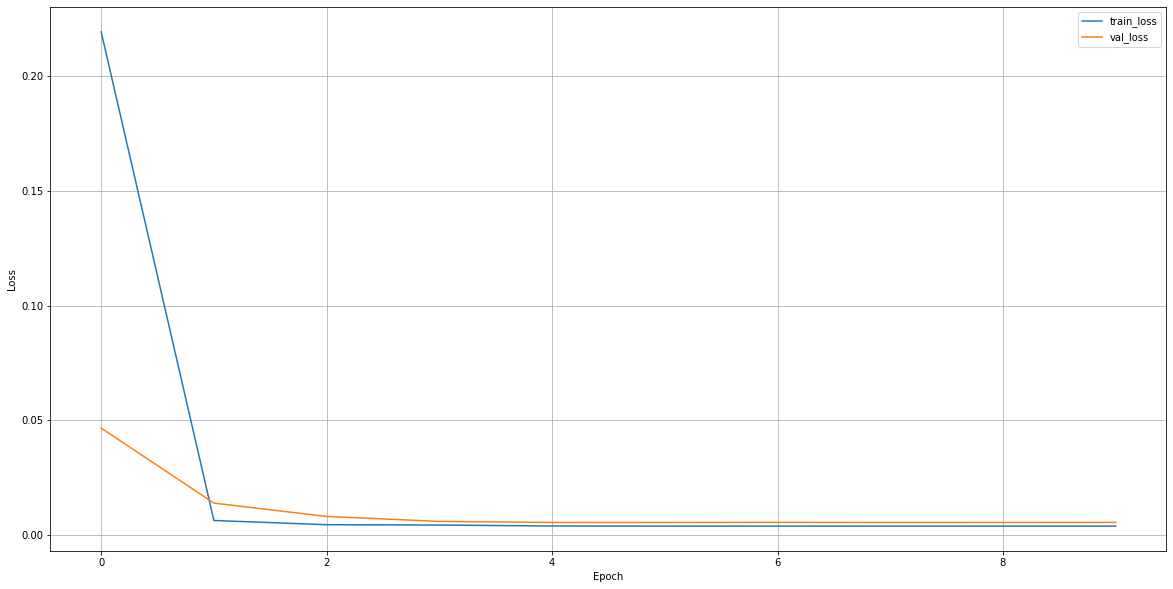

In [22]:
plot_model(models[4])

165527552/165527152 [==============================] - 7s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 196s - loss: 0.2630 - val_loss: 0.3233


2021-11-26 20:40:48.491228: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 501627, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637959248.489628535","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 501627, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.32331, saving model to Model_eff6_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 36s - loss: 0.0106 - val_loss: 0.1630

Epoch 00002: val_loss improved from 0.32331 to 0.16296, saving model to Model_eff6_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 36s - loss: 0.0056 - val_loss: 0.1166

Epoch 00003: val_loss improved from 0.16296 to 0.11663, saving model to Model_eff6_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 36s - loss: 0.0047 - val_loss: 0.0775

Epoch 00004: val_loss improved from 0.11663 to 0.07749, saving model to Model_eff6_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 36s - loss: 0.0044 - val_loss: 0.0816

Epoch 00005: val_loss did not improve from 0.07749
Epoch 6/10

Epoch 00006: LearningRateScheduler reduci

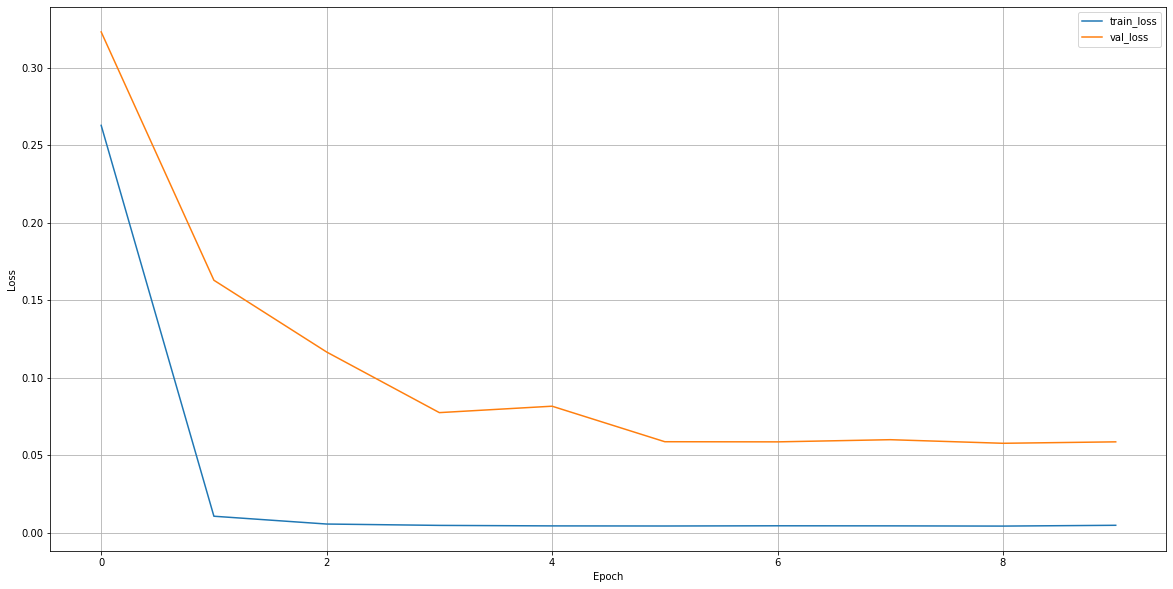

In [23]:
plot_model(models[5])

258441216/258434480 [==============================] - 3s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 240s - loss: 0.2621 - val_loss: 0.1454


2021-11-26 20:51:21.977720: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 654111, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637959881.976544316","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 654111, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.14542, saving model to Model_eff7_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 46s - loss: 0.0082 - val_loss: 0.0880

Epoch 00002: val_loss improved from 0.14542 to 0.08797, saving model to Model_eff7_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 46s - loss: 0.0048 - val_loss: 0.0245

Epoch 00003: val_loss improved from 0.08797 to 0.02445, saving model to Model_eff7_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 46s - loss: 0.0043 - val_loss: 0.0146

Epoch 00004: val_loss improved from 0.02445 to 0.01462, saving model to Model_eff7_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 46s - loss: 0.0042 - val_loss: 0.0114

Epoch 00005: val_loss improved from 0.01462 to 0.01141, saving model to Model_eff7_505.h5
Epoch 6/10

Ep

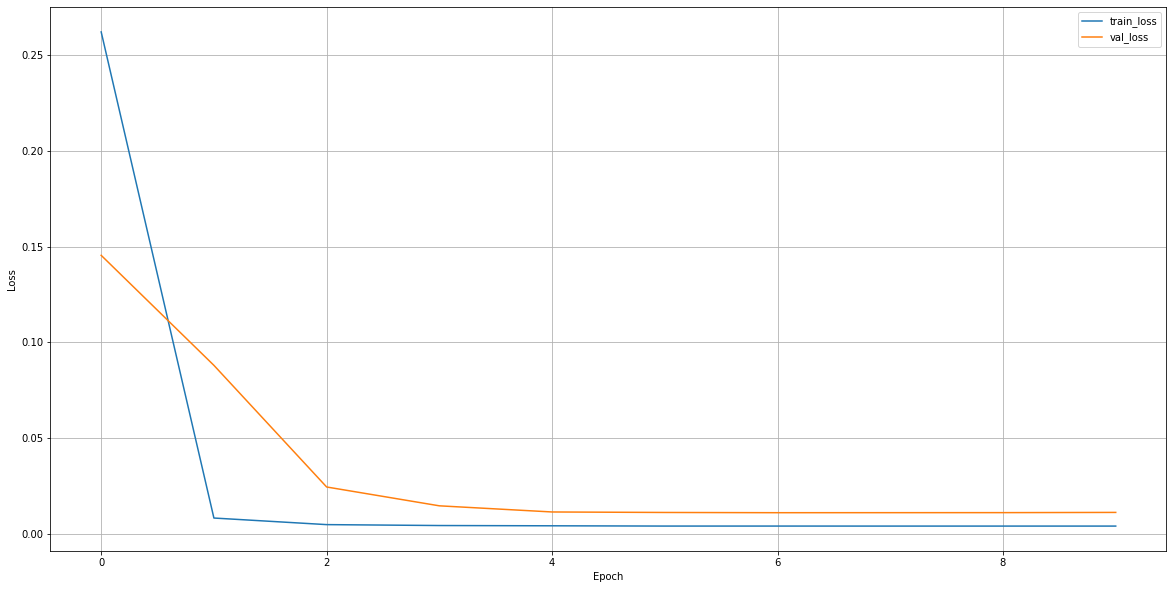

In [24]:
plot_model(models[6])

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 68s - loss: 0.1825 - val_loss: 0.0116


2021-11-26 21:00:11.290347: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 730553, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637960411.290075691","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 730553, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.01157, saving model to Model_XCP_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 15s - loss: 0.0061 - val_loss: 0.0057

Epoch 00002: val_loss improved from 0.01157 to 0.00569, saving model to Model_XCP_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 15s - loss: 0.0044 - val_loss: 0.0047

Epoch 00003: val_loss improved from 0.00569 to 0.00472, saving model to Model_XCP_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 15s - loss: 0.0040 - val_loss: 0.0044

Epoch 00004: val_loss improved from 0.00472 to 0.00439, saving model to Model_XCP_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 15s - loss: 0.0039 - val_loss: 0.0042

Epoch 00005: val_loss improved from 0.00439 to 0.00421, saving model to Model_XCP_505.h5
Epoch 6/10

Epoch 0

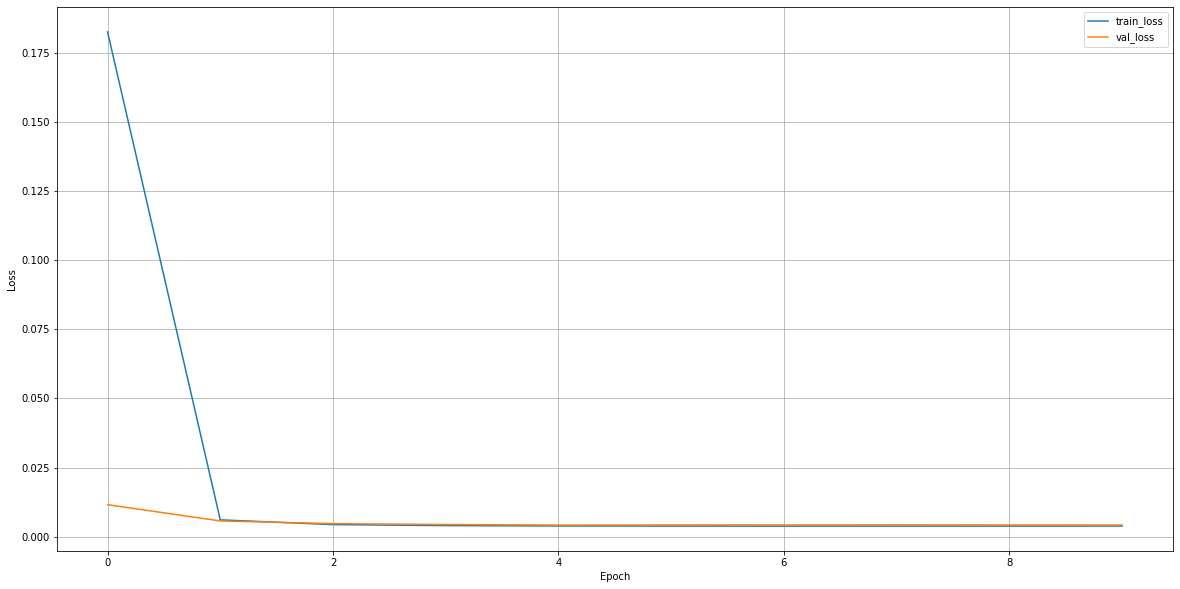

In [25]:
plot_model(models[7])

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-05.
315/315 - 77s - loss: 0.1060 - val_loss: 0.0073


2021-11-26 21:04:10.756665: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 799018, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637960650.756240101","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 799018, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.00728, saving model to Model_RN50_505.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 16s - loss: 0.0040 - val_loss: 0.0040

Epoch 00002: val_loss improved from 0.00728 to 0.00398, saving model to Model_RN50_505.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 15s - loss: 0.0038 - val_loss: 0.0039

Epoch 00003: val_loss improved from 0.00398 to 0.00388, saving model to Model_RN50_505.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 16s - loss: 0.0038 - val_loss: 0.0039

Epoch 00004: val_loss improved from 0.00388 to 0.00386, saving model to Model_RN50_505.h5
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 16s - loss: 0.0038 - val_loss: 0.0038

Epoch 00005: val_loss improved from 0.00386 to 0.00385, saving model to Model_RN50_505.h5
Epoch 6/10

Ep

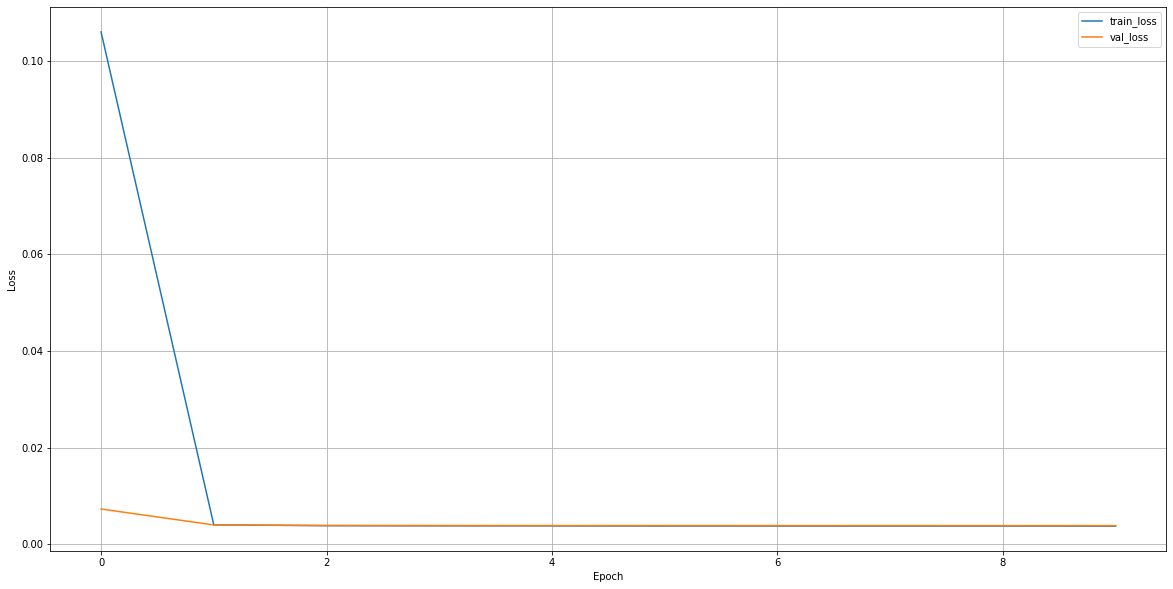

In [26]:
plot_model(models[8])